<a href="https://colab.research.google.com/github/JeanLuc-Oudshoorn/Stochastic_Linear_Programming/blob/main/multistage_stochastic_oil_refinery_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multistage Oil Purchasing and Refining with Uncertain Demand


The goal of this notebook is to solve a rather complex multistage stochastic linear programming problem. The case concerns an oil refinery that must purchase resources before demand is known. There are two subsequent stages after purchases have been made, where a decision has to be taken on how much to produce and sell during that stage. Actual demand is only known during that stage. The case comes from a university textbook, and can be read in full below.

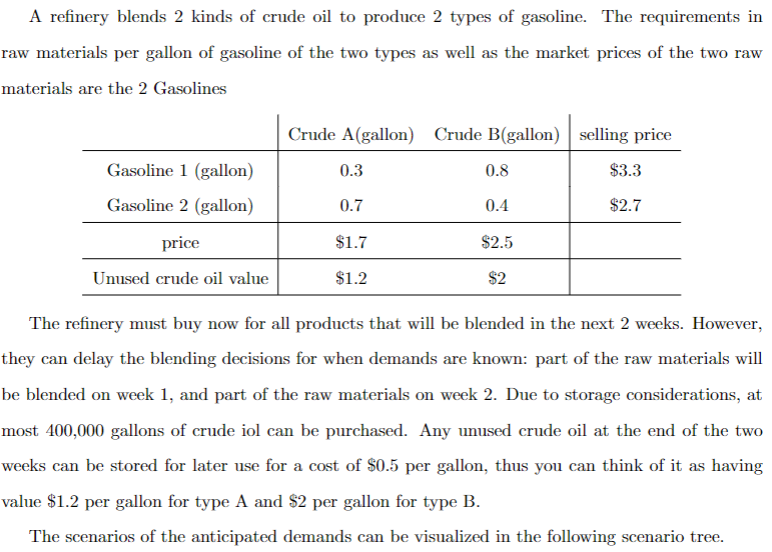

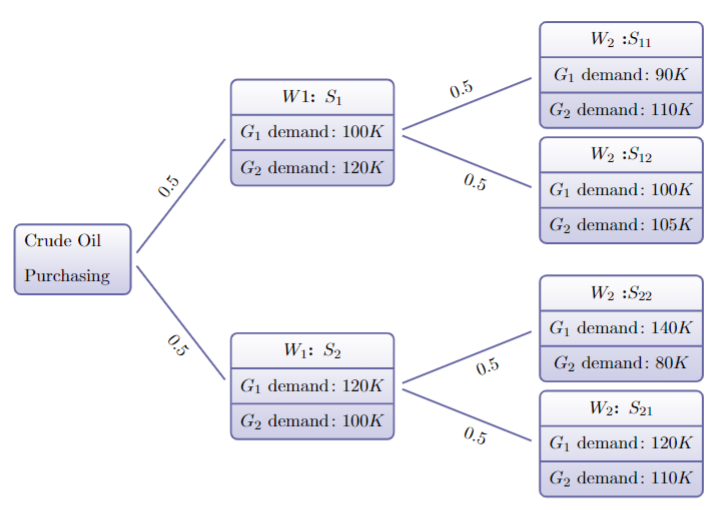

## Solving the Problem with Pulp

The first step is to import the required packages and convert the provided data into a usable format. Variable names can be stored in lists, while dictionaries are most useful to store information about variables.

In [1]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 54.8 MB/s eta 0:00:00


In [2]:
from pulp import *
import itertools

crude = ["A", "B"]
gasolines = ["G1", "G2"]
requirements = {("A", "G1"): 0.3,
                ("A", "G2"): 0.7,
                ("B", "G1"): 0.8,
                ("B", "G2"): 0.4}

buyPrice = {"A": 1.7, "B": 2.5}
sellPrice = {"G1": 3.3, "G2": 2.7}
leftoverValue = {"A": 1.2, "B": 2}

For this case, two scenarios can materialize at stage one, and four can materialize at stage two. The scenarios that can materialize in stage two depend on what happens in stage one. Itertools ca be used to create variables for all different combinations of scenarios. After this, the demand for each scenario can be defined.

In [3]:
Scenaria1 = [1, 2]
Scenaria2 = list(itertools.product(Scenaria1, Scenaria1))

demands1 = {("G1", 1): 100000, ("G2", 1): 120000,
            ("G1", 2): 120000, ("G2", 2): 100000}

demands2 = {("G1", 1, 1): 90000, ("G2", 1, 1): 110000,
            ("G1", 1, 2): 100000, ("G2", 1, 2): 105000,
            ("G1", 2, 1): 140000, ("G2", 2, 1): 80000,
            ("G1", 2, 2): 120000, ("G2", 2, 2): 110000}

Next, the problem can be instantiated. In this case, we are trying to maximize profit. The variables need to be defined after this. The first decision to be made is how much crude to purchase at the start. For both week one and week two it needs to be decided how much gasoline to blend from the resources still in inventory. The itertools product function can be used to create versions of the variables for each scenario.

In [4]:
model = LpProblem("Stochastic_LP_Problem", LpMaximize)

# Purchasing at start
P = LpVariable.dicts("P", crude, lowBound=0)

# Blended gasolines to sell in week 1
G1 = LpVariable.dicts("G1", itertools.product(gasolines, Scenaria1), lowBound=0)
# Inventory of crude oil in week 1
I1 = LpVariable.dicts("I1", itertools.product(crude, Scenaria1), lowBound=0)
# Blended gasolines to sell in week 2
G2 = LpVariable.dicts("G2", itertools.product(gasolines, Scenaria1, Scenaria1), lowBound=0)
# Inventory of crude oil in week 2
I2 = LpVariable.dicts("I2", itertools.product(crude, Scenaria1, Scenaria1), lowBound=0)

The next step is to define the objective function. A cost is incurred due to buying the crude resources at the start of the process. A profit is made for the gasoline sold in the first and second stages, as well as the residual value of leftover crude at the end of the second stage. Profits in the first stage are multiplied by 0.5 because there are two scenarios with equal probability. In the second stage, profits are multiplied by 0.25 because there are four scenarios with equal probablity.

In [5]:
model += lpSum(-buyPrice[c] * P[c] for c in crude) \
+ lpSum(0.5 * sellPrice[g] * G1[g, s] for g in gasolines for s in Scenaria1) \
+ lpSum(0.25 * sellPrice[g] * G2[g, s1, s2] for g in gasolines for (s1, s2) in Scenaria2) \
+ lpSum(0.25 * leftoverValue[c] * I2[c, s1, s2] for c in crude for (s1, s2) in Scenaria2)

Now constraints must be added. Firstly there is a limit to how much crude resouces can be stored. The implementation of this is relatively straightforward.

For the first stage the inventory is equal to the purchased resources minus what is used to blend gasoline in this stage. Furthermore, the amount of blended gasoline cannot exceed demand.

For the second stage the inventory is equal to what was left after the first stage minus what is used to blend gasoline in this stage. The amount of gasoline blended in this stage again is not allowed to exceed demand.

In [6]:
# Storage limit
model += lpSum(P[c] for c in crude) <= 400000

# Week 1
for c in crude:
    for s in Scenaria1:
        model += (I1[c, s] == P[c] - lpSum(requirements[c, g] * G1[g, s] for g in gasolines))

for g in gasolines:
    for s in Scenaria1:
        model += (G1[g, s] <= demands1[g, s])

# Week 2
for c in crude:
    for (s1, s2) in Scenaria2:
        model += (I2[c, s1, s2] == I1[c, s1] - lpSum(requirements[c, g] * G2[g, s1, s2] for g in gasolines))

for g in gasolines:
    for (s1, s2) in Scenaria2:
        model += (G2[g, s1, s2] <= demands2[g, s1, s2])

After all this work the model can be solved.

In [7]:
 model.solve()

print("Problem status is", LpStatus[model.status])

if not model.status == LpStatusOptimal:
    print("Something went wrong")

print("Variable values:")
for var in model.variables():
    print(var.name, "=", var.varValue)

print("Optimal value:", value(model.objective))

Problem status is Optimal
Variable values:
G1_('G1',_1) = 100000.0
G1_('G1',_2) = 80000.0
G1_('G2',_1) = 58636.364
G1_('G2',_2) = 83636.364
G2_('G1',_1,_1) = 90000.0
G2_('G1',_1,_2) = 100000.0
G2_('G1',_2,_1) = 120000.0
G2_('G1',_2,_2) = 120000.0
G2_('G2',_1,_1) = 109285.71
G2_('G2',_1,_2) = 105000.0
G2_('G2',_2,_1) = 80000.0
G2_('G2',_2,_2) = 80000.0
I1_('A',_1) = 103500.0
I1_('A',_2) = 92000.0
I1_('B',_1) = 122000.0
I1_('B',_2) = 128000.0
I2_('A',_1,_1) = 0.0
I2_('A',_1,_2) = 0.0
I2_('A',_2,_1) = 0.0
I2_('A',_2,_2) = 0.0
I2_('B',_1,_1) = 6285.7143
I2_('B',_1,_2) = 0.0
I2_('B',_2,_1) = 0.0
I2_('B',_2,_2) = 0.0
P_A = 174545.45
P_B = 225454.55
Optimal value: 239240.25420000005


The expected revenue for this solution is $239,240. Slightly more is bought of crude resource A than crude resouce B at the start. Afterwards, the blending decisions depend on the demand per stage. Only in scenario (1, 1) is there any leftover crude at the end of the two week period.